In [1]:
import sys 
sys.path.append('../')

from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from utils.dataset import GraphDataset, data_split
from utils.transforms import GraphStandardScaler
from utils.models import GNN, GNN2, GNN3, SGCN, SGCNcrazy

root = Path('../EEGDataset/')
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04']

graph_data = GraphDataset(root, subjects, graph_type='corr_coef', reprocess=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

#### Visualize graph of random trial

In [2]:
from torch_geometric.data import Data

# Select a trial, load channel positions
sample = graph_data[54].clone()
edge_index = sample.edge_index
print(f'number of edges: {int(edge_index.shape[1]/2)}')
elec_coord_file = root/'electrode_coordinates.csv'
elec_coord = pd.read_csv(elec_coord_file, index_col=0)

labels = elec_coord.index.values
Xn = elec_coord['x'].values
Yn = elec_coord['y'].values
Zn = elec_coord['z'].values


Xe = []
Ye = []
Ze = []
for e in edge_index.T:
    Xe += [Xn[e[0]], Xn[e[1]], None]
    Ye += [Yn[e[0]], Yn[e[1]], None]
    Ze += [Zn[e[0]], Zn[e[1]], None]


import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=Xe, y=Ye, z=Ze,
    mode='lines',
    line=dict(color='rgb(0,0,0)', width=1),
    hoverinfo='none',
)

trace2 = go.Scatter3d(
    x=Xn, y=Yn, z=Zn,
    mode = 'markers',
    name = 'electrodes',
    marker = dict(
        symbol='circle',
        size=2,
        line=dict(color='rgb(50,50,50)',width=0.5),
    ),
    text=labels,
    hoverinfo='text',
)

axis=dict(
    showbackground=False,
    showline=False,
    showgrid=False,
    showticklabels=False,
    title='',
)

layout = go.Layout(
    scene = dict(
        xaxis=dict(axis),
        yaxis=dict(axis),
        zaxis=dict(axis),
    )
)

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
fig.show()

number of edges: 1625


In [3]:
def train(dataloader, model, loss_fn, optimizer, device='cpu', clip=None):
    model.train()

    tra_loss = 0
    for batch in dataloader:

        # compute prediction error
        pred = model(batch.to(device)).squeeze()
        loss = loss_fn(pred, batch.y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)   
        optimizer.step()

        tra_loss += loss.item() * len(batch)

    return tra_loss / len(dataloader.dataset)

def valid(dataloader, model, loss_fn, device='cpu'):
    size = len(dataloader.dataset)
    model.eval()                    # set to eval to not compute gradient

    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):

            y = batch.y.to(device)
            pred = model(batch.to(device)).squeeze()
            val_loss += loss_fn(pred, y).item() * len(batch)
            correct += ((pred>0.5) == y).type(torch.float).sum().item()
    val_loss /= size
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss    


In [4]:
train_data, val_data, test_data = data_split(graph_data, [0.7, 0.1, 0.2])

# standardize values
scaler = GraphStandardScaler()
scaler.fit_transform(train_data)
scaler.transform(val_data)
scaler.transform(test_data)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)

# Training parameters
lr = 0.001
epochs = 20

# model
model = SGCNcrazy(in_channels=151, hid_channels=10).to(device)

print('Number of parameters for model: ', sum([x.reshape(-1).shape[0] for x in model.parameters()]))
print(model.parameters)

# loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.1, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device))
    val_loss.append(valid(val_loader, model, loss_fn, device=device))
    scheduler.step()
print('Done!')



Number of parameters for model:  42130
<bound method Module.parameters of SGCNcrazy(
  (conv1): GCN2Conv(151, alpha=0.5, beta=1.0)
  (lin2): Linear(in_features=19328, out_features=1, bias=True)
  (sig): Sigmoid()
)>
Epoch 1
-------------------------------


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 104000 but got size 2 for tensor number 1 in the list.

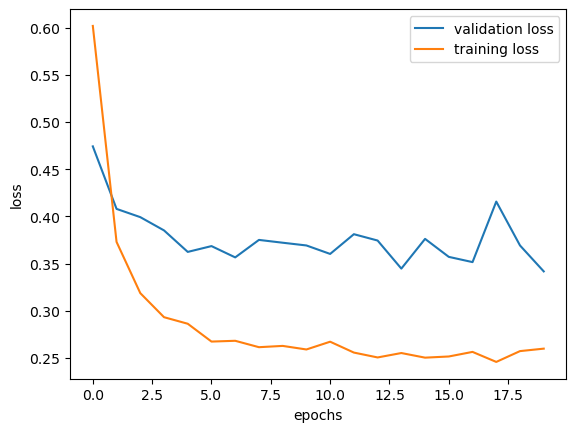

In [5]:
e = range(epochs)
plt.plot(e[:], val_loss[:], tra_loss[:])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['validation loss', 'training loss'])

In [6]:
print('Train ') 
valid(train_loader, model, loss_fn, device=device)

print('Validation ')
valid(val_loader, model, loss_fn, device=device)

print('Test ')
valid(test_loader, model, loss_fn, device=device)

Train 
Error: 
 Accuracy: 93.4%, Avg loss: 0.220615 

Validation 
Error: 
 Accuracy: 83.3%, Avg loss: 0.341704 

Test 
Error: 
 Accuracy: 88.8%, Avg loss: 0.274843 



0.2748429636249628